# <center> Финальное задание </center>
## <center> Предсказание пола клиента по транзакциям</center>

## Описание задачи 
#### Ваше задание - предсказать пол клиента, основываясь на его транзакционных исторических данных. Выполнение финального задания - это маленький шаг в большую Data Science-всесенную, поэтому отнеситесь к нему максимально серьёзно :)
#### В роли метрики выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет оптимизировать.

In [1]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install joblib

Defaulting to user installation because normal site-packages is not writeable


In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

/tmp/ipykernel_476823/1555668456.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [8]:
PATH_DATA = './data'
MODEL_PATH = "model.pkl"

In [9]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [10]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))
    return cv_res.loc[index_argmax]['test-auc-mean']

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    
    joblib.dump(clf, MODEL_PATH)
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования. 

<font color='red'><b>!!!</b></font> В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [22]:
params = {
    'eta': 0.1,
    'max_depth': 3, 
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

Добавлен параметр агрегации "sum". Метрика улучшена с 0.62 до 0.63

In [61]:
tqdm_notebook.pandas(desc="Progress")

def features_creation_basic(x): 
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'var', 'sum'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'var', 'sum'])\
                                                        .add_prefix('negative_transactions_')))
 
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)

Progress:   0%|          | 0/7560 [00:00<?, ?it/s]

Progress:   0%|          | 0/840 [00:00<?, ?it/s]

In [120]:
data_train.head()

amount,positive_transactions_min,positive_transactions_max,positive_transactions_mean,positive_transactions_median,positive_transactions_std,positive_transactions_count,positive_transactions_var,positive_transactions_sum,negative_transactions_min,negative_transactions_max,negative_transactions_mean,negative_transactions_median,negative_transactions_std,negative_transactions_count,negative_transactions_var,negative_transactions_sum
client_id,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,722.09,42665.12,18450.900313,16450.65,14360.498086,32.0,2.062239e+08,590428.81,-39772.06,-6.13,-1881.786653,-269.295,4111.309461,472.0,1.690287e+07,-888203.30
0002f4661e0d4d2ae097d78552dad022,312.99,15909.56,2364.986667,723.37,5083.124389,9.0,2.583815e+07,21284.88,-9400.52,-6.58,-289.255194,-123.305,693.683636,258.0,4.811970e+05,-74627.84
00081e0eca8ad94e493691f8f00099c6,360.75,5423.80,1981.352400,1373.80,1704.496840,25.0,2.905309e+06,49533.81,-5424.42,-1.89,-379.101205,-144.935,701.946022,166.0,4.927282e+05,-62930.80
0019bebcb5435df3103a5b0b52f5fc6b,14.93,20247.50,1032.745050,722.43,1743.349204,301.0,3.039266e+06,310856.26,-36518.54,-0.32,-743.432256,-361.160,2027.349534,665.0,4.110146e+06,-494382.45
001c8191ecac499718b33dc293a99e5b,145.62,3616.52,1250.236923,723.71,950.703133,39.0,9.038364e+05,48759.24,-15907.79,-11.56,-1394.087964,-178.110,2918.020385,167.0,8.514843e+06,-232812.69


In [121]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:18:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.632+-0.011, Trees: 24


In [125]:
# Число деревьев для XGBoost имеет смысл выставлять по результатам на кросс-валидации 
clf, submission = fit_predict(params, 70, data_train, data_test, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:18:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


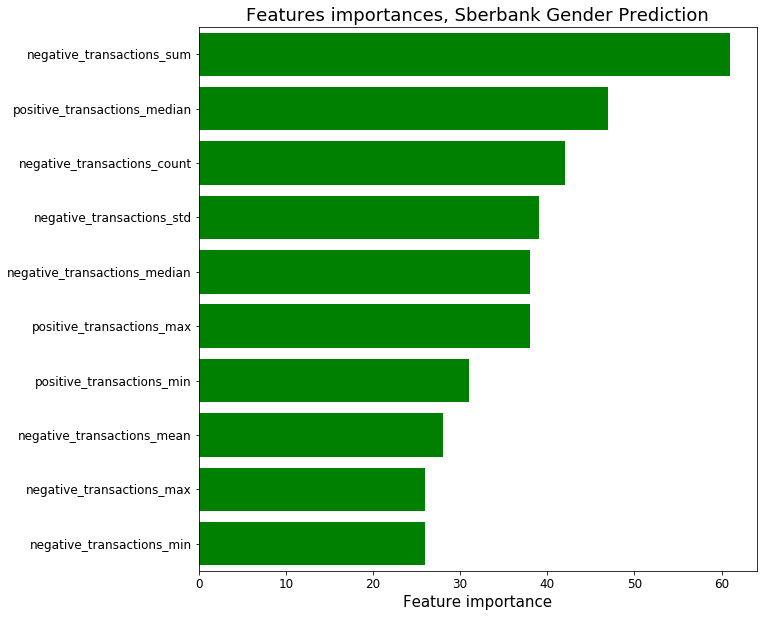

In [126]:
draw_feature_importances(clf, 10)

In [127]:
# Сохраняем результат моделирования

submission.to_csv('basic_features_submission.csv')

<font size=3>Видим, что результат на кросс-валидации = <font color='red'><b>62.2%</b></font> ROC AUC.

## Advanced features
Добавим дополнительные переменные по каждому пользователю в модель. <br>
Для этого будем анализировать дни недели, часы и состояние дня/ночи во время покупки - в каждом из случаев будем считать частоту транзакций в соответствующей категории относитеьно всех остальных категорий. <br>
То есть если, например, клиент в 70% случае совершал ночные траты, то мы получим вектор [0.7, 0.3] для этого случая в качестве частот транзакций ночью/днём.

In [43]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [44]:
# trasnsactions features

def calc_time_of_day(x):
    if (x >= 6) and (x < 12):
        return 'morning'
    elif (x >= 12) and (x < 18):
        return 'daytime'
    elif (x >= 18) and (x <= 23):
        return 'evening'
    else:
        return 'night'


def calc_day_type(day):
    if day == 4:
        return 'friday'
    elif (day == 5 or day == 6):
        return 'weekend'
    return 'weekday'

for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)
    #features from datetime
    df['ordered_day'] = df.apply(lambda row: int(row['trans_time'].split(' ')[0]),axis=1)
    df['time'] = df.apply(lambda row: row['trans_time'].split(' ')[1],axis=1)
    df['hours'] = df.apply(lambda row: int(row['trans_time'].split(' ')[1].split(':')[0]),axis=1)
    df['time_of_day'] = df.apply(lambda row: calc_time_of_day(row['hour']),axis=1)
    df['day_type'] = df.apply(lambda row: calc_day_type(row['ordered_day']%7),axis=1)

    df['week_num'] =  df['ordered_day'] // 7
    df['day_of_week'] =  df['ordered_day'] % 7
    df['month'] = df['ordered_day'] // 30 % 12
    df['day_of_month'] = df['ordered_day'] // 30 

In [45]:
transactions_train.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender,day,hour,night,ordered_day,time,hours,time_of_day,day_type,week_num,day_of_week,month,day_of_month
client_id,,,,,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0,5,14,-2,313,14:52:03,14,daytime,weekend,44,5,10,10
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0,3,14,-2,150,14:10:49,14,daytime,weekday,21,3,5,5
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0,3,12,-2,122,12:38:32,12,daytime,weekday,17,3,4,4
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0,5,13,-2,159,13:22:34,13,daytime,weekend,22,5,5,5
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0,5,12,-2,257,12:06:54,12,daytime,weekend,36,5,8,8


In [46]:
transactions_test.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,day,hour,night,ordered_day,time,hours,time_of_day,day_type,week_num,day_of_week,month,day_of_month
client_id,,,,,,,,,,,,,,,,,,,
002218c52073faaf23bb26df2cffb138,54 10:35:16,6011,2010,-360.78,NaN,Saint Petersburg,0,5,10,-2,54,10:35:16,10,morning,weekend,7,5,1,1
002218c52073faaf23bb26df2cffb138,52 11:00:46,6011,2010,-1446.74,NaN,Saint Petersburg,0,3,11,-2,52,11:00:46,11,morning,weekday,7,3,1,1
002218c52073faaf23bb26df2cffb138,52 17:14:19,5541,1110,-672.38,NaN,Saint Petersburg,0,3,17,-2,52,17:14:19,17,daytime,weekday,7,3,1,1
002218c52073faaf23bb26df2cffb138,353 16:33:39,5499,1010,-324.94,804245,Saint Petersburg,0,3,16,-2,353,16:33:39,16,daytime,weekday,50,3,11,11
002218c52073faaf23bb26df2cffb138,244 08:48:14,5812,1010,-173.87,464318,Saint Petersburg,0,6,8,-2,244,08:48:14,8,morning,weekend,34,6,8,8


In [91]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum', 'skew', 'kurt'])\
                                                         .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum', 'skew', 'kurt'])\
                                                         .add_prefix('negative_transactions_')))
    
    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True)).add_prefix('mcc_'))
    features.append(pd.Series(x['mcc_code'].agg(['count']).add_prefix('mcc_count')))
    
    features.append(pd.Series(x['trans_type'].value_counts(normalize=True).add_prefix('trans_')))
    features.append(pd.Series(x['trans_type'].agg(['count']).add_prefix('trans_count')))

    features.append(pd.Series(x['day_of_month'].value_counts(normalize=True).add_prefix('month_day_')))
    features.append(pd.Series(x['month'].value_counts(normalize=True).add_prefix('month_')))
    features.append(pd.Series(x['week_num'].value_counts(normalize=True).add_prefix('week_')))
    
    
    #features.append(pd.Series(x['term_id'].value_counts(normalize=True)).add_prefix('term_'))
    #features.append(pd.Series(x['mcc_code'].agg(['count']).add_prefix('mcc_count')))
    
    
 
    return pd.concat(features)    

In [92]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .apply(features_creation_advanced).unstack(-1)

In [14]:
# data_train = transactions_train.groupby(transactions_train.index)\
#                                .apply(test_feature).unstack(-1)
# data_test = transactions_test.groupby(transactions_test.index)\
#                              .apply(test_feature).unstack(-1)

In [15]:
#transactions_train.head()

In [16]:
#validation
#y = data_train.join(gender_train, how='inner')['gender']
#data_train, data_valid, y_train, y_valid = train_test_split(data_train, y, test_size=0.15, shuffle=False)

In [93]:
print(data_train.shape)
print(data_test.shape)

(7560, 406)
(840, 395)


In [94]:
a = np.intersect1d(data_train.columns, data_test.columns)
data_train = data_train[a]
#data_valid = data_valid[a]

In [95]:
##data_test = data_out[-840:]
##print(data_test.shape)

In [96]:
print(data_train.shape)
#print(data_valid.shape)
print(data_test.shape)

(7560, 395)
(840, 395)


In [97]:
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:18:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:18:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.872+-0.008, Trees: 173


0.8719518592853

In [98]:
def gridSearch(data_valid, target_valid):
    params = {
        'eta': [0.2, 0.1, 0.05, 0.01],
        'max_depth': [3, 5], #[3, 4, 5, 7, 9], 
        'subsample': [0.5],  #[0.5, 0.7, 0.9, 1],
        'colsample_bytree': [0.5], #[0.5, 0.7, 0.9, 1],

        'gamma': [1], #[0, 0.1, 0.5, 1],
        'lambda': [1], #[0, 0.5, 1], #L2 regularization 
        'alpha':  [0.5], # [0, 0.5, 1],
        'min_child_weight': [0.1], #[0, 0.1, 0.3, 0.5, 1],

        'eval_metric': ['auc'],
        'objective': ['binary:logistic'] ,
        'booster': ['gbtree', 'dart'],
        'njobs': [-1],
        'tree_method': ['approx', 'exact']
    }
    best_roc_auc = 0
    paramsToFunction = {}
    bestParams = {}
    for eta in params['eta']:
        for max_depth in params['max_depth']:
            for subsample in params['subsample']:
                for colsample_bytree in params['colsample_bytree']:
                    for gamma in params['gamma']:
                        for lambda_param in params['lambda']:
                            for alpha in params['alpha']:
                                for min_child_weight in params['min_child_weight']:
                                    for eval_metric in params['eval_metric']:
                                        for objective in params['objective']:
                                            for booster in params['booster']:
                                                for njobs in params['njobs']:
                                                    for tree_method in params['tree_method']:
                                                        paramsToFunction['learning_rate'] = eta
                                                        paramsToFunction['max_depth'] = max_depth
                                                        paramsToFunction['subsample'] = subsample
                                                        paramsToFunction['colsample_bytree'] = colsample_bytree
                                                    
                                                        paramsToFunction['gamma'] = gamma
                                                        paramsToFunction['lambda'] = lambda_param
                                                        paramsToFunction['alpha'] = alpha
                                                        paramsToFunction['min_child_weight'] = min_child_weight
    
                                                        paramsToFunction['eval_metric'] = eval_metric
                                                        paramsToFunction['objective'] = objective
                                                        paramsToFunction['booster'] = booster
                                                        paramsToFunction['njobs'] = njobs
                                                        paramsToFunction['tree_method'] = tree_method
                                                        score = cv_score(paramsToFunction, data_valid, target_valid) 
                                                        if(score > best_roc_auc):
                                                            best_roc_auc = score
                                                            bestParams = paramsToFunction
                                                            bestParams['eta'] = paramsToFunction['learning_rate']
                                                            print(bestParams)
    return bestParams, best_roc_auc

In [ ]:
best_params, best_roc_auc = gridSearch(data_train, target)
print("TOP ROC_AUC = ", best_roc_auc)

/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:19:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.863+-0.008, Trees: 75
{'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 1, 'lambda': 1, 'alpha': 0.5, 'min_child_weight': 0.1, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'booster': 'gbtree', 'njobs': -1, 'tree_method': 'approx', 'eta': 0.2}


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:19:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.863+-0.009, Trees: 82
{'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 1, 'lambda': 1, 'alpha': 0.5, 'min_child_weight': 0.1, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'booster': 'gbtree', 'njobs': -1, 'tree_method': 'exact', 'eta': 0.2}


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:20:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.863+-0.010, Trees: 96


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:21:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.863+-0.008, Trees: 106
{'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 1, 'lambda': 1, 'alpha': 0.5, 'min_child_weight': 0.1, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'booster': 'dart', 'njobs': -1, 'tree_method': 'exact', 'eta': 0.2}


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.851+-0.005, Trees: 45


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.850+-0.010, Trees: 32


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:22:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.857+-0.010, Trees: 60


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:23:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:23:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.852+-0.008, Trees: 41


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:23:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.871+-0.009, Trees: 164
{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 1, 'lambda': 1, 'alpha': 0.5, 'min_child_weight': 0.1, 'eval_metric': 'auc', 'objective': 'binary:logistic', 'booster': 'gbtree', 'njobs': -1, 'tree_method': 'approx', 'eta': 0.1}


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:24:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.868+-0.008, Trees: 98


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:24:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:24:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.869+-0.009, Trees: 156


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:27:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.868+-0.007, Trees: 123


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:28:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.861+-0.011, Trees: 76


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:29:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.864+-0.009, Trees: 104


/home/sjava/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:29:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print(best_params)

In [ ]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации 
clf, submission = fit_predict(best_params, 70, data_train, data_test, target)

In [ ]:
import pickle

 
with open('my_dict.pkl', 'wb') as f:
    pickle.dump(best_params, f)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[0]	validation_0-logloss:0.67371
[1]	validation_0-logloss:0.66074
[2]	validation_0-logloss:0.64964
[0]	validation_0-logloss:0.67355
[0]	validation_0-logloss:0.67369
[3]	validation_0-logloss:0.63958
[1]	validation_0-logloss:0.65971
[1]	validation_0-logloss:0.66094
[2]	validation_0-logloss:0.64829
[4]	validation_0-logloss:0.63164
[2]	validation_0-logloss:0.64868
[3]	validation_0-logloss:0.63919
[5]	validation_0-logloss:0.62411
[3]	validation_0-logloss:0.63888
[4]	validation_0-logloss:0.63048
[6]	validation_0-logloss:0.61698
[5]	validation_0-logloss:0.62319
[0]	validation_0-logloss:0.67354
[4]	validation_0-logloss:0.63046
[7]	validation_0-logloss:0.61060
[0]	validation_0-logloss:0.67351
[0]	validation_0-logloss:0.67353
[0]	validation_0-logloss:0.67372
[6]	validation_0-logloss:0.61636
[1]	validation_0-logloss:0.66036
[8]	validation_0-logloss:0.60512
[5]	validation_0-logloss:0.62281
[0]	validation_0-logloss:0.67360
[1]	validation_

[4]	validation_0-logloss:0.68121
[8]	validation_0-logloss:0.67563
[3]	validation_0-logloss:0.68289
[3]	validation_0-logloss:0.68287
[5]	validation_0-logloss:0.67983
[5]	validation_0-logloss:0.67991
[7]	validation_0-logloss:0.67698
[1]	validation_0-logloss:0.68598
[4]	validation_0-logloss:0.68138
[4]	validation_0-logloss:0.68135
[5]	validation_0-logloss:0.67967
[9]	validation_0-logloss:0.67426
[3]	validation_0-logloss:0.68292
[8]	validation_0-logloss:0.67557
[6]	validation_0-logloss:0.67845
[6]	validation_0-logloss:0.67835
[5]	validation_0-logloss:0.67986
[2]	validation_0-logloss:0.68439
[5]	validation_0-logloss:0.67990
[9]	validation_0-logloss:0.67419
[6]	validation_0-logloss:0.67819
[7]	validation_0-logloss:0.67691
[4]	validation_0-logloss:0.68140
[7]	validation_0-logloss:0.67702
[3]	validation_0-logloss:0.68284
[6]	validation_0-logloss:0.67841
[6]	validation_0-logloss:0.67845
[7]	validation_0-logloss:0.67673
[5]	validation_0-logloss:0.67990
[8]	validation_0-logloss:0.67550
[8]	valida

[2]	validation_0-logloss:0.66182
[8]	validation_0-logloss:0.63576
[2]	validation_0-logloss:0.66275
[2]	validation_0-logloss:0.66316
[1]	validation_0-logloss:0.67092
[1]	validation_0-logloss:0.67115
[3]	validation_0-logloss:0.65445
[9]	validation_0-logloss:0.63155
[3]	validation_0-logloss:0.65556
[3]	validation_0-logloss:0.65616
[4]	validation_0-logloss:0.64829
[2]	validation_0-logloss:0.66322
[0]	validation_0-logloss:0.67954
[4]	validation_0-logloss:0.64876
[2]	validation_0-logloss:0.66274
[4]	validation_0-logloss:0.64970
[5]	validation_0-logloss:0.64238
[3]	validation_0-logloss:0.65538
[0]	validation_0-logloss:0.67943
[1]	validation_0-logloss:0.67068
[5]	validation_0-logloss:0.64289
[0]	validation_0-logloss:0.67948
[5]	validation_0-logloss:0.64342
[3]	validation_0-logloss:0.65568
[6]	validation_0-logloss:0.63687
[1]	validation_0-logloss:0.67069
[4]	validation_0-logloss:0.64894
[2]	validation_0-logloss:0.66238
[6]	validation_0-logloss:0.63765
[1]	validation_0-logloss:0.67033
[7]	valida

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 4),
                         'n_estimators': range(10, 20, 40)},
             scoring='roc_auc', verbose=True)

In [46]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [47]:
grid_search.best_estimator_.predict()
target_valid = data_valid.join(gender_train, how='inner')['gender']
cv_score(grid_params, data_valid, target_valid)

AttributeError: 'XGBClassifier' object has no attribute 'copy'

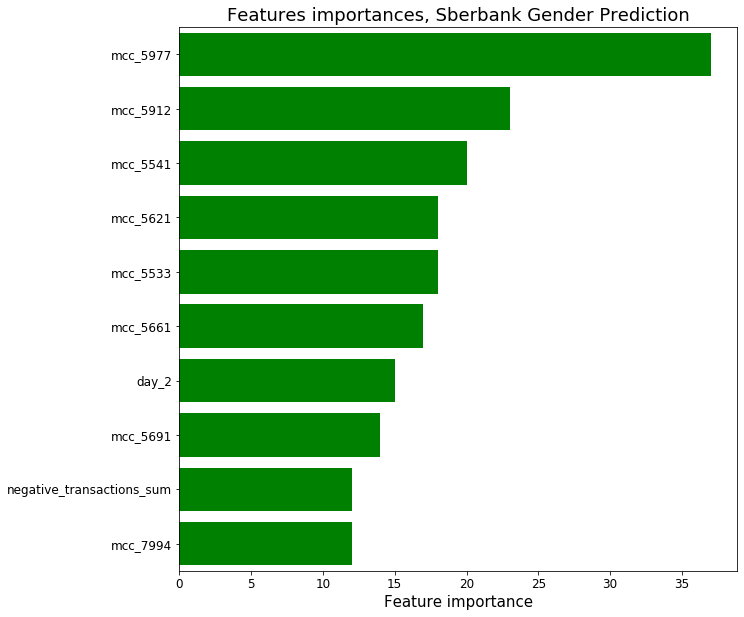

In [30]:
draw_feature_importances(clf, 10)

<font size=3>Добавление новых переменных улучшило наши результаты ROC AUC с <b>62.2%</b> до <font color='red'><b>68.4%</b></font>, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

In [268]:
# Сохраняем результат моделирования

submission.to_csv('advanced_features_submission.csv')

### <font color='red'>Цель задания:
Полученная модель должна иметь ROC AUC на Public-части тестовой выборки (на лидерборде) <b>не менее 80%.

In [344]:
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

#tr_mcc_codes = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
#tr_types = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/tr_types.csv', sep=';', index_col='tr_type')
#transactions = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/transactions.csv', index_col='customer_id')
#gender_train = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/gender_train.csv', index_col='customer_id')
#gender_test = pd.read_csv('/kaggle/input/python-and-analyze-data-final-project/gender_test_kaggle_sample_submission.csv', index_col='customer_id')
#transactions_train = transactions.join(gender_train, how='inner')
#transactions_test = transactions.join(gender_test, how='inner')


In [345]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

transactions_train.head()

,trans_time,mcc_code,trans_type,amount,term_id,trans_city,Unnamed: 0,gender,day,hour,night
client_id,,,,,,,,,,,
0002cf30347684df542e1a931f356875,313 14:52:03,4829,2370,-2170.07,888990,Saint Petersburg,6806,0,5,14,-2
0002cf30347684df542e1a931f356875,150 14:10:49,6011,2010,-1445.64,NaN,Saint Petersburg,6806,0,3,14,-2
0002cf30347684df542e1a931f356875,122 12:38:32,5912,1010,-107.07,NaN,Saint Petersburg,6806,0,3,12,-2
0002cf30347684df542e1a931f356875,159 13:22:34,6011,2010,-2892.86,NaN,Saint Petersburg,6806,0,5,13,-2
0002cf30347684df542e1a931f356875,257 12:06:54,5912,1010,-164.49,469965,Saint Petersburg,6806,0,5,12,-2


In [356]:
tqdm_notebook.pandas(desc="Progress:")

def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    
    features.append(pd.Series(x[x['amount']>=0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum', 'var'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count', 'sum', 'var'])\
                                                        .add_prefix('negative_transactions_')))

    features.append(pd.Series(x['mcc_code'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['trans_type'].value_counts(normalize=True).add_prefix('trans_')))
    
    
    return pd.concat(features)

In [357]:
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

target = data_train.join(gender_train, how='inner')['gender']
target.value_counts()

Progress::   0%|          | 0/7560 [00:00<?, ?it/s]

Progress::   0%|          | 0/840 [00:00<?, ?it/s]

gender
0    4199
1    3361
Name: count, dtype: int64

In [358]:
print(data_train.shape)
print(data_test.shape)

(7560, 308)
(840, 297)


In [359]:
a = np.intersect1d(data_train.columns, data_test.columns)
data_train = data_train[a]
print(data_train.shape)

(7560, 297)


In [360]:
X = data_train.copy()
y = target
test_df = data_test.copy()

X.fillna(-1, inplace=True)
test_df.fillna(-1, inplace=True)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test_df = scaler.fit_transform(test_df)

X.shape, test_df.shape

((7560, 297), (840, 297))

In [361]:
test_df.shape[1]

297

In [362]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
import tensorflow as tf
input_dim = test_df.shape[1]
model_keras = Sequential()
model_keras.add(Dense(256, activation='sigmoid', input_dim=input_dim))
model_keras.add(BatchNormalization())
model_keras.add(Dense(1024, activation='relu'))
model_keras.add(BatchNormalization())
model_keras.add(Dense(256, activation='sigmoid'))
model_keras.add(Dense(32, activation='relu'))
model_keras.add(Dense(1, activation='sigmoid'))

# Compile the model_keras
model_keras.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()])

In [363]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

model_keras.fit(
    X, 
    y, 
    epochs=100, 
    validation_split=0.2, 
    batch_size=64,
    verbose=1,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

y_pred = model_keras.predict(test_df)

submission = pd.DataFrame(index=data_test.index)
submission['probability'] = y_pred
submission.to_csv('submission_kears.csv')
submission.head()

Epoch 1/100
95/95 [==============================] - 4s 18ms/step - loss: 0.5285 - auc_21: 0.8112 - val_loss: 0.6495 - val_auc_21: 0.8362 - lr: 0.0010
Epoch 2/100
95/95 [==============================] - 1s 14ms/step - loss: 0.4405 - auc_21: 0.8721 - val_loss: 0.6098 - val_auc_21: 0.8483 - lr: 0.0010
Epoch 3/100
95/95 [==============================] - 1s 13ms/step - loss: 0.3992 - auc_21: 0.8958 - val_loss: 0.5519 - val_auc_21: 0.8367 - lr: 0.0010
Epoch 4/100
95/95 [==============================] - 1s 12ms/step - loss: 0.3535 - auc_21: 0.9195 - val_loss: 0.5148 - val_auc_21: 0.8321 - lr: 0.0010
Epoch 5/100
95/95 [==============================] - 1s 11ms/step - loss: 0.3154 - auc_21: 0.9370 - val_loss: 0.5489 - val_auc_21: 0.8224 - lr: 0.0010
Epoch 6/100
95/95 [==============================] - 1s 11ms/step - loss: 0.2758 - auc_21: 0.9520 - val_loss: 0.6166 - val_auc_21: 0.8156 - lr: 0.0010
Epoch 7/100
95/95 [==============================] - 1s 11ms/step - loss: 0.2385 - auc_21: 0.9

,probability
client_id,
002218c52073faaf23bb26df2cffb138,0.946398
0069d4050c7aeb341317e2e125e8fd2e,0.022844
0083fb89aea18c408a5534cdd38d7692,0.021277
014021fa559786c81e9e1d48d378aabb,0.997060
01759f92152bbb3de79f9493a4a5cd6d,0.674173


In [368]:
from keras.models import load_model
model = load_model('.mdl_wts.hdf5')

y_pred = model.predict(test_df)

submission = pd.DataFrame(index=data_test.index)
submission['probability'] = y_pred
#submission.to_csv('submission_kears.csv')
submission.head()

27/27 [==============================] - 0s 3ms/step


,probability
client_id,
002218c52073faaf23bb26df2cffb138,0.808804
0069d4050c7aeb341317e2e125e8fd2e,0.445945
0083fb89aea18c408a5534cdd38d7692,0.169912
014021fa559786c81e9e1d48d378aabb,0.773650
01759f92152bbb3de79f9493a4a5cd6d,0.322024


In [369]:
joblib.dump(model_keras, MODEL_PATH)

['model.pkl']

In [374]:
model = joblib.load("model.pkl")


In [379]:
import pickle
pickle.dump(model_keras, open(MODEL_PATH, 'wb'))